# <h1 style='Text-align: center;'>**Detección de Tumores Cerebrales**</h1>
# <h1 style='Text-align: center;'>Clasificación de imágenes cerebrales por resonancia magnética</h1>

`Creado por: Erick Eduardo Robledo Montes`

---
---
## Contenido

<p style='Text-align: justify;'>En este Jupyter Notebook se emplean imágenes cerebrales por resonancia magnética extraídas del repositorio <i>Brain MRI segmentation</i>, del sitio web <i>Kaggle</i> que contiene 3,929 imágenes y 3,929 imágenes segmentadas (máscaras).</p> 

<p style='Text-align: justify;'>El proyecto se centra en el uso de técnicas avanzadas de <i>aprendizaje profundo</i> para resolver el problema de clasificación de imágenes cerebrales por resonancia magnética. El objetivo principal es crear un modelo de red neuronal convolucional que utilice <i>transfer learning</i> para identificar aquellas imágenes que contienen tumores. En una segunda etapa del proyecto, se hará el <i>deploy</i> del modelo generado.

## Etapas de ambos modelos de redes neuronales

* *Preparación de datos*
* *Preprocesamiento de imágenes*
* *Diseño del modelo*
* *Entrenamiento del modelo*
* *Evaluación del modelo*
* *Validación del modelo*
* *Despliegue del modelo*

### Librerías

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

import time

%matplotlib inline
from IPython.display import Image, display
#from skimage import io

import tensorflow as tf
import seaborn as sns
from tqdm import tqdm
#from skimage.color import rgb2gray
from tensorflow.keras import layers, optimizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model,Sequential, load_model, save_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import (
    LabelEncoder,
    LabelBinarizer,
)
from sklearn.metrics import (
    roc_curve,
    auc,
) 
import cv2
from sklearn.preprocessing import StandardScaler, normalize

In [2]:
# Obtenemos el nombre de la GPU disponible (si hay alguna)
device_name = tf.test.gpu_device_name()

# Verificamos si la GPU está disponible
if device_name != '/device:GPU:0':
  # Si la GPU no está disponible, producimos un error
  raise SystemError('GPU device not found')

# Si la GPU está disponible, imprimimos un mensaje que indica su ubicación
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Variables constantes

In [3]:
ROOT = "../kaggle_3m/"
root = "../kaggle_3m"
img_tumor = "../kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5"
img_s_tumor = "../kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_4"
INIT_LR = 3e-4
DECAY = 1e-6
BS = 32
CLASSES = ["No Existe Tumor" ,"Tumor Detectado"]

## Generación de modeo de red neuronal para clasificar tumores cerebrales

### Preparación de datos
---

* Limpieza y organización de datos.
* División de datos en entrenamiento, validación y prueba.
* Aumento artificial de datos.


#### Limpieza y organización de datos

Función para obtener la ruta de los datos

In [4]:
def get_data_path(root: str) -> list:
    """
    Recorre una ruta de directorio 'root' y devuelve una lista de pares que 
    contienen el nombre del directorio y la ruta de cada archivo en el directorio.
    
    Args:
        root (str): Ruta del directorio a recorrer.
        
    Returns:
        list: Una lista de tuplas que contiene el nombre del directorio y la ruta 
        de cada archivo en el directorio.
    """
    
    # Inicializar una lista vacía para almacenar los resultados.
    data_path = []
    
    # Recorrer la ruta del directorio raíz.
    for sub_dir_path in glob.glob(root + "*"):
        try:
            # Extraer el nombre del directorio.
            dir_name = sub_dir_path.split('/')[-1]
            
            # Recorrer la ruta de cada archivo en el directorio.
            for filename in os.listdir(sub_dir_path):
                # Construir la ruta completa de la máscara.
                mask_path = sub_dir_path + '/' + filename
                
                # Agregar el nombre del directorio y la ruta de la máscara a la lista de resultados.
                data_path.extend([dir_name, mask_path])
        except Exception as e:
            # Si se produce un error, imprimirlo en la consola.
            print(e)
    
    return data_path

data_path = get_data_path(ROOT)

[WinError 267] El nombre del directorio no es válido: '../kaggle_3m\\data.csv'
[WinError 267] El nombre del directorio no es válido: '../kaggle_3m\\README.md'


Función para obtener rutas a imágenes y máscaras

In [5]:
def get_images_path(root: str):
    """
    Esta función recibe una ruta (root) y devuelve dos listas, una 
    con las rutas a las imágenes y otra con las rutas a las máscaras.

    Args:
        root (str): Ruta a la carpeta que contiene las subcarpetas 
        con las imágenes y las máscaras.

    Returns:
        Tuple[List[str], List[str]]: Tupla con dos listas de strings, 
        una con las rutas a las imágenes y otra con las rutas a las máscaras.
    """
    images = []  # Lista para guardar las rutas a las imágenes.
    labels = []  # Lista para guardar las rutas a las máscaras.
    
    # Iteramos sobre las subcarpetas de la ruta indicada.
    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)  # Ruta completa a la subcarpeta actual.
        
        # Si la ruta corresponde a una carpeta, procesamos las imágenes y las máscaras.
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)  # Número de imágenes/máscaras en la subcarpeta.
            
            # Iteramos sobre el número de imágenes/máscaras y construimos las rutas.
            for i in range(iters): 
                file = os.path.join(path, d) + '_' + str(i+1) + '.tif'  # Ruta a la imagen.
                mask = os.path.join(path, d) + '_' + str(i+1) + '_mask.tif'  # Ruta a la máscara.
                
                # Agregamos las rutas a las listas correspondientes.
                images.append(file)
                labels.append(mask)
    
    # Devolvemos las dos listas como una tupla.
    return images, labels

# Ejemplo de uso de la función.
imgs, labels = get_images_path(root)


100%|██████████| 112/112 [00:00<00:00, 888.85it/s]


In [6]:
# Se obtienen los nombres de archivo de las imágenes
filenames = data_path[::2]

# Se obtienen los nombres de archivo de las máscaras correspondientes a las imágenes
masks = data_path[1::2]

Creación y filtrado de *DataFrame* con Pandas

In [7]:
# Creamos un DataFrame utilizando las dos listas de rutas de la función anterior
df = pd.DataFrame(data={"patient_id": filenames,"img_path": masks})

# Seleccionamos solo las filas del DataFrame que no contienen la palabra "mask" en la ruta
original_img = df[~df['img_path'].str.contains("mask")]

# Seleccionamos solo las filas del DataFrame que contienen la palabra "mask" en la ruta
mask_img = df[df['img_path'].str.contains("mask")]

Creación de *DataFrame* con el id del paciente, y con rutas a imégenes y máscaras

In [8]:
# Crear un DataFrame con las rutas a las imágenes originales, las imágenes de máscara y los identificadores de paciente.
mri_df = pd.DataFrame({
    "patient_id": original_img.patient_id.values,  # Obtener los identificadores de paciente de las imágenes originales.
    "img_path": imgs,  # Obtener las rutas a las imágenes originales.
    'mask_path': labels  # Obtener las rutas a las imágenes de máscara.
})

In [9]:
mri_df

,patient_id,img_path,mask_path
0,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...
1,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...
2,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...
3,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...
4,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...
...,...,...,...
3924,kaggle_3m\TCGA_HT_A61B_19991127,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...
3925,kaggle_3m\TCGA_HT_A61B_19991127,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...
3926,kaggle_3m\TCGA_HT_A61B_19991127,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...
3927,kaggle_3m\TCGA_HT_A61B_19991127,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...


Crear lista con el diagnóstico de cada imagen normalizada, asignando la etiqueta 1 si contiene un tumores y 0 en caso contrario

In [10]:
# Asignar el dispositivo para la ejecución del código
with tf.device('/gpu:0'):
  
    # Imprimir mensaje de uso de GPU
    print("Using GPU...")
    
    # Crear una lista con el valor máximo de cada máscara redimensionada y normalizada
    diagnosis = [
        int(np.max(cv2.imread(mri_df["mask_path"][i])) / 255.) 
        for i in range(mri_df.shape[0])
    ]

Using GPU...


Guardar información de imágenes, máscaras y diagnósticos en un archivo csv


In [11]:
# Creamos un nuevo DataFrame que contiene la información de las imágenes, máscaras y diagnósticos 
mri_df = pd.DataFrame({
    "patient_id": original_img.patient_id.values, 
    "img_path": imgs,
    'mask_path': labels,
    'mask': diagnosis
    })

# Guardamos el DataFrame en un archivo csv
mri_df.to_csv('../datasets/' + 'mri_df.csv', index = False)

Cargar conjunto de datos crudo y visualizarlo

In [12]:
raw_dataset = pd.read_csv('../datasets/' + 'mri_df.csv')
raw_dataset

,patient_id,img_path,mask_path,mask
0,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,0
1,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,0
2,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,0
3,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,0
4,kaggle_3m\TCGA_CS_4941_19960909,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,../kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS_494...,0
...,...,...,...,...
3924,kaggle_3m\TCGA_HT_A61B_19991127,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,0
3925,kaggle_3m\TCGA_HT_A61B_19991127,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,0
3926,kaggle_3m\TCGA_HT_A61B_19991127,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,0
3927,kaggle_3m\TCGA_HT_A61B_19991127,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,../kaggle_3m\TCGA_HT_A61B_19991127\TCGA_HT_A61...,0


Contando valores de la columna `mask` en el `raw_dataset`

In [13]:
# Conteo de cada valor único en la columna "mask"
raw_dataset["mask"].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

Graficando los registros para visualizar en cuántas máscaras se detectaron tumores

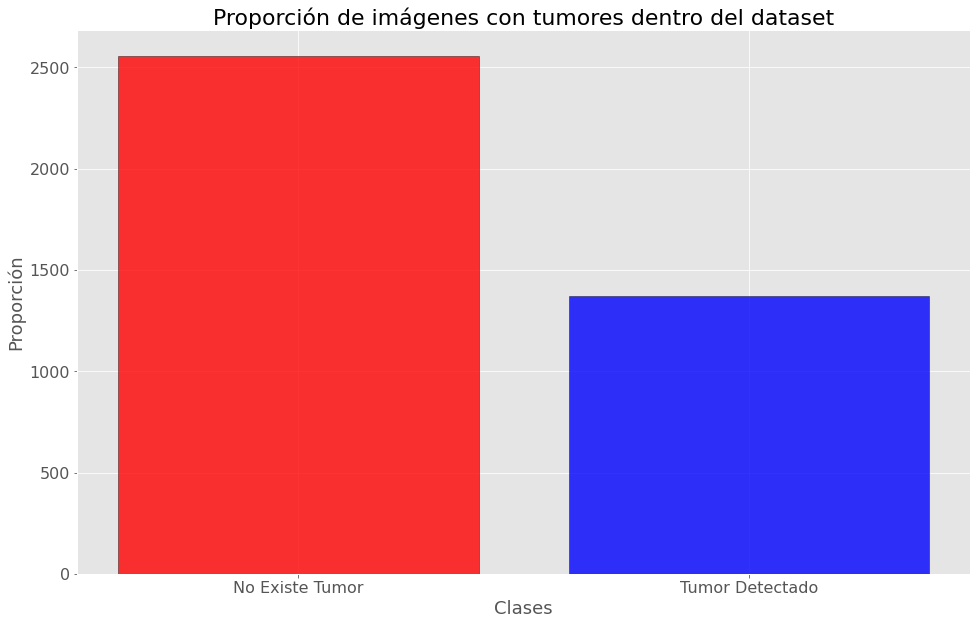

In [14]:
# Definir los nombres de las dos clases
X = ["No Existe Tumor" ,"Tumor Detectado"]

# Definir los colores para cada clase
colors = ["red", "blue"]

# Crear un arreglo de valores para el eje X
X_axis = np.arange(len(X))

# Seleccionar el estilo de gráfico "ggplot"
plt.style.use('ggplot')

# Definir el tamaño del gráfico
plt.figure(figsize=(16,10))

# Crear un gráfico de barras
# Los valores de las barras se obtienen de la columna "mask" del dataset
plt.bar(X_axis, raw_dataset["mask"].value_counts(), alpha = 0.8, edgecolor = 'black', color = colors)

# Añadir un título al gráfico
plt.title(r'Proporción de imágenes con tumores dentro del dataset', size=22)

# Etiquetar las marcas en el eje X con los nombres de las clases
plt.xticks(X_axis, X)

# Añadir una etiqueta a los ejes X y Y
plt.ylabel(r'Proporción', size=18)
plt.xlabel(r'Clases', size=18)

# Ajustar el tamaño de las marcas en los ejes X y Y
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)

# Mostrar el gráfico
plt.show()

Conteo de cada valor único en la columna `patient_id`

In [15]:
raw_dataset["patient_id"].value_counts()

kaggle_3m\TCGA_HT_A61B_19991127    88
kaggle_3m\TCGA_HT_A61A_20000127    88
kaggle_3m\TCGA_HT_7881_19981015    80
kaggle_3m\TCGA_FG_A60K_20040224    73
kaggle_3m\TCGA_DU_5872_19950223    71
                                   ..
kaggle_3m\TCGA_CS_4944_20010208    20
kaggle_3m\TCGA_HT_7602_19951103    20
kaggle_3m\TCGA_HT_7874_19950902    20
kaggle_3m\TCGA_CS_6290_20000917    20
kaggle_3m\TCGA_CS_5393_19990606    20
Name: patient_id, Length: 110, dtype: int64

La función `show_images` muestra dos imágenes relacionadas, la imagen y su máscara, en una figura con cuatro subfiguras. Esta función utiliza las siguientes tareas para lograrlo:

* Lee las imágenes en su resolución original y en su versión con 
máscara. Las imágenes se leen utilizando las extensiones de archivo proporcionadas.

* Redimensiona ambas imágenes a una resolución de $64x64$ píxeles.
Crea una figura con cuatro subfiguras.

* Muestra las imágenes originales y redimensionadas en su respectiva subfigura. Se elimina la necesidad de escribir código casi idéntico varias veces usando un bucle *for*.

* Ajusta los parámetros de la figura antes de mostrarla para que las imágenes se muestren correctamente.

* Elimina los ejes en las cuatro subfiguras usando un bucle *for*.
Muestra la figura con las cuatro imágenes.



In [25]:
def show_images(path: str):
    """
    Lee la imagen en su resolución original, la redimensiona a una resolución
    de 64x64 píxeles y muestra ambas imágenes en una figura con cuatro subfiguras.
    """

    # Leer las imagenes en su resolución original
    image, mask = [cv2.imread(path + ext) for ext in [".tif", "_mask.tif"]]

    # Redimensionar las imagenes a una resolución de 64x64 píxeles
    resized_image, resized_mask = [cv2.resize(img, (64, 64)) for img in [image, mask]]

    # Crear una figura con cuatro subfiguras para mostrar ambas imágenes
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    # Mostrar las imágenes en su resolución original y redimensionada
    for i, img_type in enumerate(["Imágen", "Máscara"]):
        # Mostrar la imagen original
        axes[i][0].imshow(cv2.cvtColor(image if img_type == "Imágen" else mask, cv2.COLOR_BGR2RGB))
        axes[i][0].set_title(f"{img_type} Original", size=18)

        # Mostrar la imagen redimensionada
        axes[i][1].imshow(cv2.cvtColor(resized_image if img_type == "Imágen" else resized_mask, cv2.COLOR_BGR2RGB))
        axes[i][1].set_title(f"{img_type} Redimensionada (64$X$64)", size=18)

        # Eliminar ejes
        axes[i][0].axis('off')
        axes[i][1].axis('off')

    # Ajustar los parámetros de la figura para que las imágenes se muestren correctamente
    plt.tight_layout()

    # Mostrar la figura con las cuatro imágenes
    plt.show()

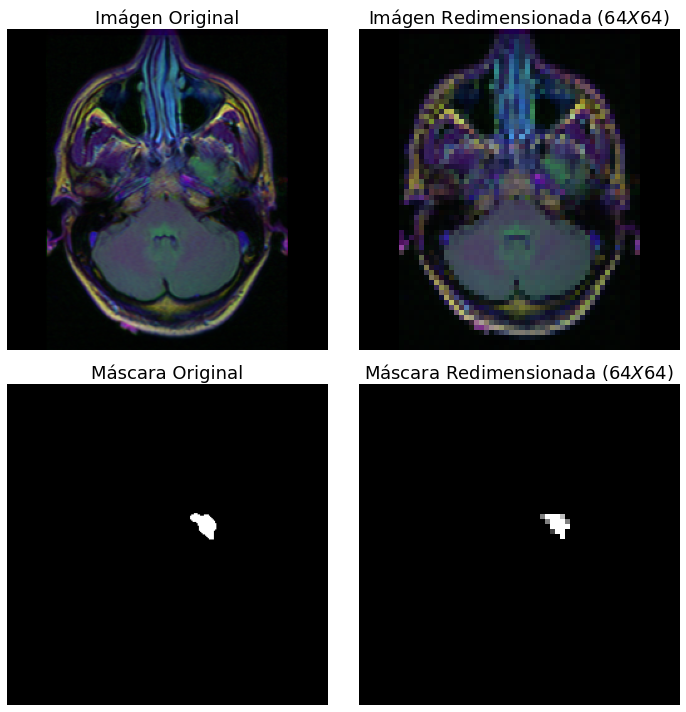

In [26]:
# Mandar a llamar a la función para visualizar las imágenes redimensionadas
img_show = show_images(img_tumor)


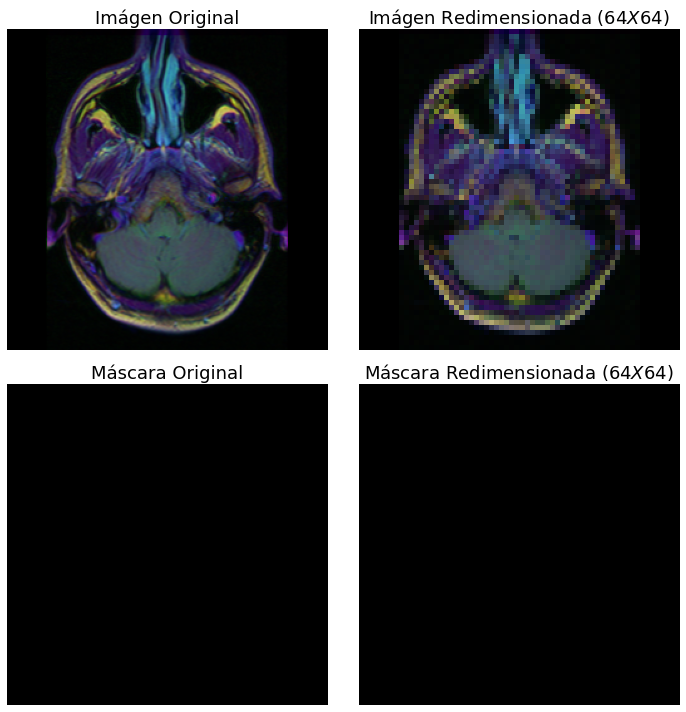

In [27]:
# Mandar a llamar a la función para visualizar las imágenes redimensionadas
img_show = show_images(img_s_tumor)

#### División de datos en entrenamiento, validación y prueba

In [16]:
# Cargar dataset
raw_dataset = pd.read_csv('../datasets/' + 'mri_df.csv')

In [17]:
# Eliminar columna "patient_id"
raw_dataset = raw_dataset.drop(columns = ['patient_id'])
raw_dataset.shape

(3929, 3)

In [18]:
# Convertir los datos en la columna de máscara a formato de string, para usar el modo categórico en flow_from_dataframe
raw_dataset['mask'] = raw_dataset['mask'].apply(lambda x: str(x))
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   img_path   3929 non-null   object
 1   mask_path  3929 non-null   object
 2   mask       3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


#### Aumento artificial de datos

In [19]:
# Dividir los datos en entrenamiento y prueba
train, test = train_test_split(raw_dataset, test_size = 0.15, random_state=42)

##### Preprocesamiento de imagenes

In [20]:
# Creamos un generador de datos que escale los datos de 0 a 1 y haga una división de validación de 0,15
datagen = ImageDataGenerator(
    rescale=1./255.,
    fill_mode = 'nearest',
    rotation_range = 2, 
    shear_range = 0.02,
    zoom_range = 0.02,
    zca_whitening=False, 
    samplewise_center=True, 
    validation_split = 0.15,
    )

In [21]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='img_path',
y_col='mask',
subset="training",
batch_size=BS,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='img_path',
y_col='mask',
subset="validation",
batch_size=BS,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creamos un generador de datos para imágenes de prueba
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='img_path',
y_col='mask',
batch_size=BS,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


### Entrenamiento del modelo
---

In [11]:
# Obtenemos el modelo base de VGG16 
basemodel = VGG16(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

# Congelamos los pesos del modelo
for layer in basemodel.layers:
    layers.trainable = False

# Agregamos una cabecera de clasificación al modelo base
headmodel = basemodel.output
headmodel = layers.AveragePooling2D(pool_size = (2,2))(headmodel)
headmodel = layers.Flatten(name= 'flatten')(headmodel)
headmodel = layers.Dense(256, activation = "relu")(headmodel)
headmodel = layers.Dropout(0.5)(headmodel)
headmodel = layers.Dense(256, activation = "relu")(headmodel)
headmodel = layers.Dropout(0.5)(headmodel)
headmodel = layers.Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

opt = Adam (
    lr = INIT_LR, 
    decay = DECAY,
)

# Compilamos el modelo
model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics= ["accuracy"])

# Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights = True)

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="../models/" + "vgg16_model" + ".h5", verbose=1, save_best_only=True)

In [12]:
with tf.device('/gpu:0'):
    print("Training the model with gpu . . .")
    history = model.fit(
        train_generator, 
        steps_per_epoch= train_generator.n // BS, 
        epochs = 50, 
        validation_data= valid_generator, 
        validation_steps= valid_generator.n // BS, 
        callbacks=[checkpointer, earlystopping]
    )

model.save("../models/" + "vgg16_model" + ".h5")

Training the model with gpu . . .
Epoch 1/50
88/88 [==============================] - 91s 813ms/step - loss: 0.7148 - accuracy: 0.5879 - val_loss: 0.5834 - val_accuracy: 0.6875

Epoch 00001: val_loss improved from inf to 0.58342, saving model to ../models\vgg16_model.h5
Epoch 2/50
88/88 [==============================] - 57s 642ms/step - loss: 0.5899 - accuracy: 0.6602 - val_loss: 0.4909 - val_accuracy: 0.7312

Epoch 00002: val_loss improved from 0.58342 to 0.49087, saving model to ../models\vgg16_model.h5
Epoch 3/50
88/88 [==============================] - 57s 644ms/step - loss: 0.5051 - accuracy: 0.7085 - val_loss: 0.4167 - val_accuracy: 0.7917

Epoch 00003: val_loss improved from 0.49087 to 0.41670, saving model to ../models\vgg16_model.h5
Epoch 4/50
88/88 [==============================] - 57s 648ms/step - loss: 0.4610 - accuracy: 0.7540 - val_loss: 0.3953 - val_accuracy: 0.7875

Epoch 00004: val_loss improved from 0.41670 to 0.39533, saving model to ../models\vgg16_model.h5
Epoch 

In [13]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro
model_json = model.to_json()
with open("../weights/" + "classifier-vgg16-model.json", "w") as json_file:
    json_file.write(model_json)

### Evaluación del modelo
---

La clase `ModelChart` es una clase que se utiliza para generar gráficos de pérdida y precisión de un modelo de aprendizaje profundo entrenado con Keras. Toma tres argumentos en su constructor `__init__`: `history`, que es el objeto de historial de entrenamiento del modelo de Keras; `model_name`, que es el nombre del modelo; y `epochs`, que es el número de épocas de entrenamiento del modelo. La clase tiene tres métodos:

* `loss_accuracy_chart(self, path: str)`: Este método genera un gráfico de pérdida y precisión del modelo y lo guarda en una ubicación especificada por `path`. El gráfico muestra la pérdida de entrenamiento y validación, así como la precisión de entrenamiento y validación a lo largo de las épocas de entrenamiento.

* `accuracy_chart(self, path: str)`: Este método genera un gráfico de precisión del modelo y lo guarda en una ubicación especificada por `path`. El gráfico muestra la precisión de entrenamiento y validación a lo largo de las épocas de entrenamiento.

* `loss_chart(self, path: str)`: Este método genera un gráfico de pérdida del modelo y lo guarda en una ubicación especificada por `path`. El gráfico muestra la pérdida de entrenamiento y validación a lo largo de las épocas de entrenamiento.

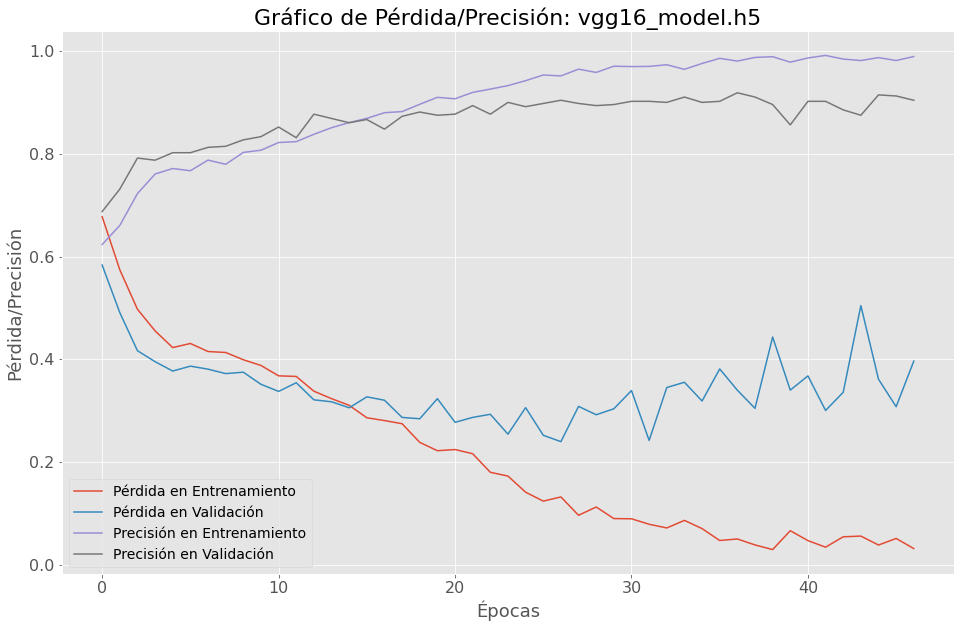

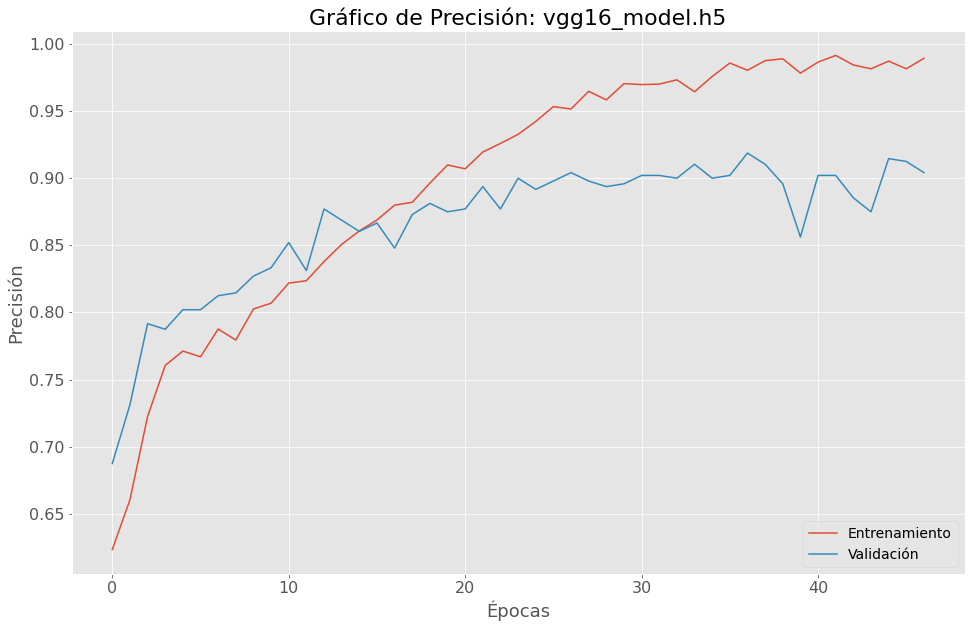

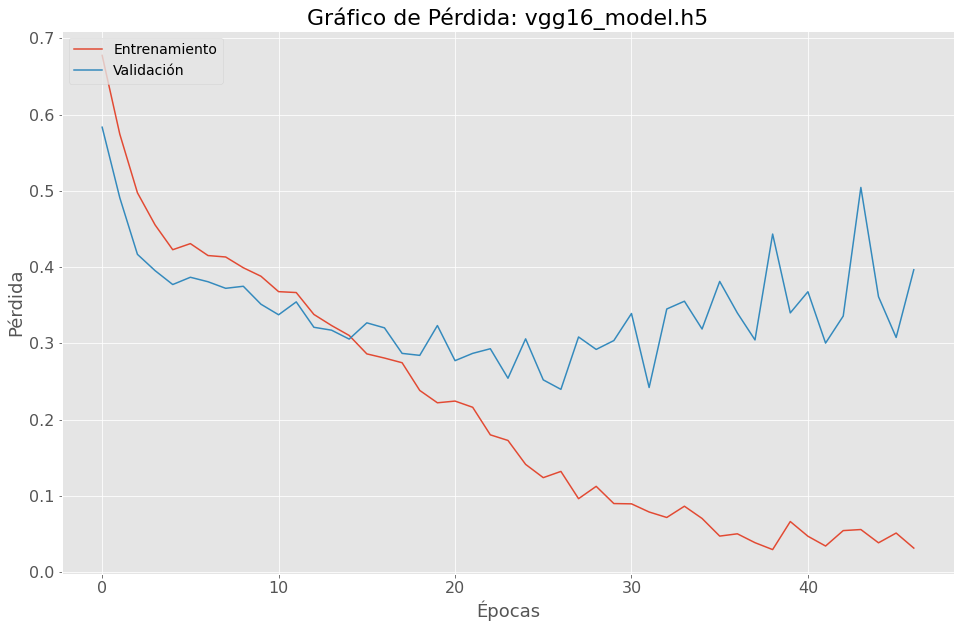

In [14]:
class ModelChart:
    """
    Clase para generar gráficos de pérdida y precisión de un modelo de aprendizaje profundo.

    Args:
        history (obj): Objeto de historial de entrenamiento de un modelo de Keras.
        model_name (str): Nombre del modelo.
        epochs (int): Número de épocas de entrenamiento del modelo.
    """

    def __init__(self, history, model_name: str, epochs: int):
        self.history = history
        self.model_name = model_name
        self.epochs = epochs

    def loss_accuracy_chart(self, path: str):
        """
        Genera y guarda un gráfico de pérdida y precisión del modelo.

        Args:
            path (str): Ruta de destino para guardar el gráfico.
        """

        N = self.epochs

        plt.style.use("ggplot")
        plt.figure(figsize=(16, 10))
        plt.plot(self.history.history["loss"], label="Pérdida en Entrenamiento")
        plt.plot(self.history.history["val_loss"], label="Pérdida en Validación")
        plt.plot(self.history.history["accuracy"], label="Precisión en Entrenamiento")
        plt.plot(self.history.history["val_accuracy"], label="Precisión en Validación")
        plt.title(r"Gráfico de Pérdida/Precisión: " + self.model_name, size=22)
        plt.xlabel(r"Épocas", size=18)
        plt.ylabel(r"Pérdida/Precisión", size=18)
        plt.tick_params(axis='x', labelsize=16)
        plt.tick_params(axis='y', labelsize=16)
        plt.legend(loc="lower left", fontsize=14)
        plt.savefig(path + 'loss_accuracy_' + self.model_name + '.png')
        plt.show()

    def accuracy_chart(self, path: str):
        """
        Genera y guarda un gráfico de precisión del modelo.

        Args:
            path (str): Ruta de destino para guardar el gráfico.
        """

        plt.style.use('ggplot')
        plt.figure(figsize=(16, 10))
        plt.plot(self.history.history['accuracy'], label="Precisión en Entrenamiento")
        plt.plot(self.history.history['val_accuracy'], label="Precisión en Validación")
        plt.title(r"Gráfico de Precisión: " + self.model_name, size=22)
        plt.xlabel(r"Épocas", size=18)
        plt.ylabel(r"Precisión", size=18)
        plt.tick_params(axis='x', labelsize=16)
        plt.tick_params(axis='y', labelsize=16)
        plt.legend(['Entrenamiento', 'Validación'], loc='lower right', fontsize=14)
        plt.savefig(path + 'accuracy_' + self.model_name + '.png')
        plt.show()

    def loss_chart(self, path: str):
        """
        Genera y guarda un gráfico de pérdida del modelo.

        Args:
            path (str): Ruta de destino para guardar el gráfico.
        """
        
        plt.style.use('ggplot')
        plt.figure(figsize = (16, 10))
        plt.plot(self.history.history['loss'], label="Pérdida en Entrenamiento")
        plt.plot(self.history.history['val_loss'], label="Pérdida en Validación")
        plt.title(r"Gráfico de Pérdida: " + self.model_name, size=22)
        plt.xlabel(r"Épocas", size=18)
        plt.ylabel(r"Pérdida", size=18)
        plt.tick_params(axis='x', labelsize=16)
        plt.tick_params(axis='y', labelsize=16)
        plt.legend(['Entrenamiento', 'Validación'], loc='upper left', fontsize=14)
        plt.savefig(path + 'loss_' + self.model_name + '.png')
        plt.show()

model_plot = ModelChart(history, "vgg16_model.h5", 10)

model = model_plot.loss_accuracy_chart("../reports/")
accuracy = model_plot.accuracy_chart("../reports/")
loss = model_plot.loss_chart("../reports/")

La clase `ModelEvaluation` es una clase que se utiliza para evaluar modelos de clasificación y generar visualizaciones de resultados. Tiene los siguientes atributos:

* `conf_matrix`: una matriz de confusión del modelo, que es proporcionada como argumento al constructor de la clase.
* `model_name`: el nombre del modelo, que también se proporciona como argumento al constructor de la clase.

La clase tiene tres métodos:

* `confusion_matrix(path: str, labels: list)`: este método genera una visualización de la matriz de confusión del modelo. Toma dos argumentos de entrada: `path`, que es la ruta donde se guardarán las visualizaciones generadas, y `labels`, que es una lista de etiquetas de las clases.
* `parameters()`: este método calcula y muestra en la consola diferentes métricas de evaluación del modelo, como precisión, sensibilidad, especificidad y puntuación F1 para cada una de las clases en la matriz de confusión.

In [25]:
class ModelEvaluation:
    """
    Clase para evaluar modelos de clasificación y generar visualizaciones de resultados.

    Args:
        conf_matrix (np.ndarray): Matriz de confusión del modelo.
        model_name (str): Nombre del modelo.

    Atributos:
        conf_matrix (np.ndarray): Matriz de confusión del modelo.
        model_name (str): Nombre del modelo.
    """

    def __init__(self, conf_matrix: np.ndarray, model_name: str):
        """
        Constructor de la clase ModelEvaluation.

        Args:
            conf_matrix (np.ndarray): Matriz de confusión del modelo.
            model_name (str): Nombre del modelo.
        """
        self.conf_matrix = conf_matrix
        self.model_name = model_name

    def confusion_matrix(self, path: str, labels: list):
        """
        Genera una visualización de la matriz de confusión del modelo.

        Args:
            path (str): Ruta donde se guardarán las visualizaciones generadas.
            labels (list): Lista de etiquetas de las clases.
        """
        df_cm = pd.DataFrame(self.conf_matrix, columns=labels, index=labels)
        df_cm.index.name = 'Original'
        df_cm.columns.name = 'Predicción'
        plt.figure(figsize=(16, 10))
        plt.title(r"Matriz de Confusión: " + self.model_name, size=22)
        plt.xlabel(r"Original", size=18)
        plt.ylabel(r"Predicción", size=18)
        plt.tick_params(axis='x', labelsize=16)
        plt.tick_params(axis='y', labelsize=16)
        sns.heatmap(df_cm / np.sum(df_cm), fmt='.2%', annot=True, annot_kws={'size': 22})
        plt.savefig(path + 'confusion_matrix_' + self.model_name + '.png')
        plt.show()

    def parameters(self):
        """
        Calcula y muestra en consola diferentes métricas de evaluación del modelo.
        """
        TP_class1 = self.conf_matrix[0, 0]
        FN_class1 = self.conf_matrix[0, 1]
        FP_class1 = self.conf_matrix[1, 0]
        TN_class1 = self.conf_matrix[1, 1]

        sensit_class1 = TP_class1 / (TP_class1 + FN_class1)
        spec_class1 = TN_class1 / (FP_class1 + TN_class1)
        prec_class1 = TP_class1 / (TP_class1 + FP_class1)
        fscore_class1 = 2 * (sensit_class1 * prec_class1) / (sensit_class1 + prec_class1)

        TP_class2 = self.conf_matrix[1, 1]
        FN_class2 = self.conf_matrix[1, 0]
        FP_class2 = self.conf_matrix[0, 1]
        TN_class2 = self.conf_matrix[0, 0]

        sensit_class2 = TP_class2 / (TP_class2 + FN_class2)
        spec_class2 = TN_class2 / (FP_class2 + TN_class2)
        prec_class2 = TP_class2 / (TP_class2 + FP_class2)
        fscore_class2 = 2 * (sensit_class2 * prec_class2) / (sensit_class2 + prec_class2)

        accuracy = (self.conf_matrix[0,0] + self.conf_matrix[1,1]) / sum(sum(self.conf_matrix))
        print("Test Model Accuracy: {:.4f}".format(accuracy))
        print(f". . .")
        print(CLASSES[0] + " " + "Sensitivity: {:.4f}".format(sensit_class1))
        print(CLASSES[0] + " " + "Specificity: {:.4f}".format(spec_class1))
        print(CLASSES[0] + " " + "Precision: {:.4f}".format(prec_class1))
        print(CLASSES[0] + " " + "F1-Score: {:.4f}".format(fscore_class1))
        print(f". . .")
        print(CLASSES[1] + " " + "Sensitivity: {:.4f}".format(sensit_class2))
        print(CLASSES[1] + " " + "Specificity: {:.4f}".format(spec_class2))
        print(CLASSES[1] + " " + "Precision: {:.4f}".format(prec_class2))
        print(CLASSES[1] + " " + "F1-Score: {:.4f}".format(fscore_class2))

In [23]:
# Cargar el modelo previamente guardado
loaded_model = load_model("../models/" + "vgg16_model" + ".h5")

# Configurar el optimizador con una tasa de aprendizaje inicial y una tasa de decaimiento
opt = Adam(lr = INIT_LR, decay = DECAY)

# Compilar el modelo cargado con el optimizador, función de pérdida y métricas
loaded_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Realizar predicciones en el conjunto de prueba usando el modelo cargado
prob_test_prediction = loaded_model.predict(test_generator)

# Obtener las etiquetas predichas tomando el índice del valor máximo de probabilidad
test_prediction = np.argmax(prob_test_prediction, axis=1)

# Obtener las etiquetas verdaderas del conjunto de prueba
y_true = test_generator.classes

# Imprimir un informe de clasificación que muestra métricas de desempeño del modelo
print(classification_report(y_true, test_prediction, target_names=CLASSES))

# Calcular la matriz de confusión para evaluar el desempeño del modelo
conf_matrix = confusion_matrix(y_true, test_prediction)

                 precision    recall  f1-score   support

No Existe Tumor       0.89      0.90      0.90       383
Tumor Detectado       0.82      0.80      0.81       207

       accuracy                           0.87       590
      macro avg       0.85      0.85      0.85       590
   weighted avg       0.87      0.87      0.87       590



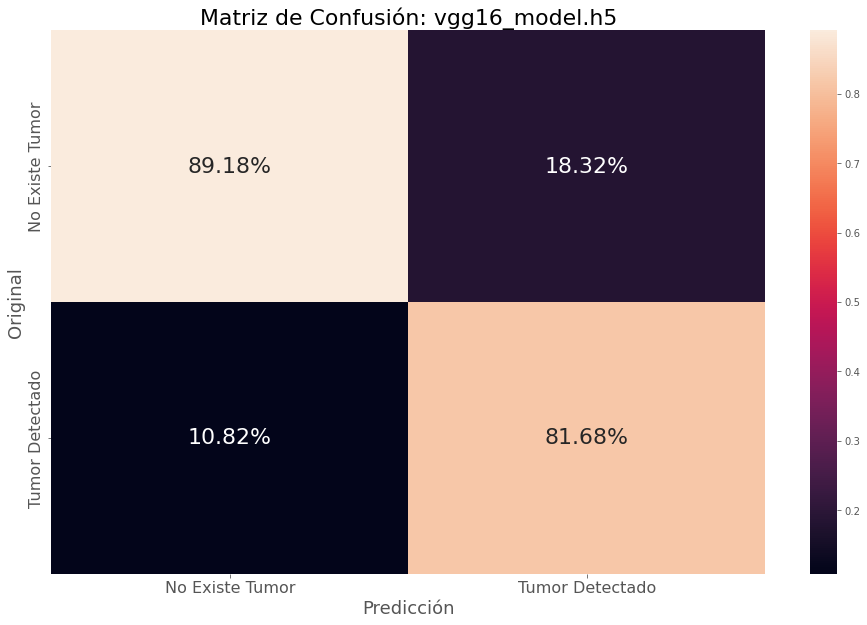

Test Model Accuracy: 0.8661
. . .
No Existe Tumor Sensitivity: 0.9034
No Existe Tumor Specificity: 0.7971
No Existe Tumor Precision: 0.8918
No Existe Tumor F1-Score: 0.8975
. . .
Tumor Detectado Sensitivity: 0.7971
Tumor Detectado Specificity: 0.9034
Tumor Detectado Precision: 0.8168
Tumor Detectado F1-Score: 0.8068


In [26]:
model = ModelEvaluation(conf_matrix, "vgg16_model" + ".h5")
model.confusion_matrix("../reports/", CLASSES)
model.parameters()

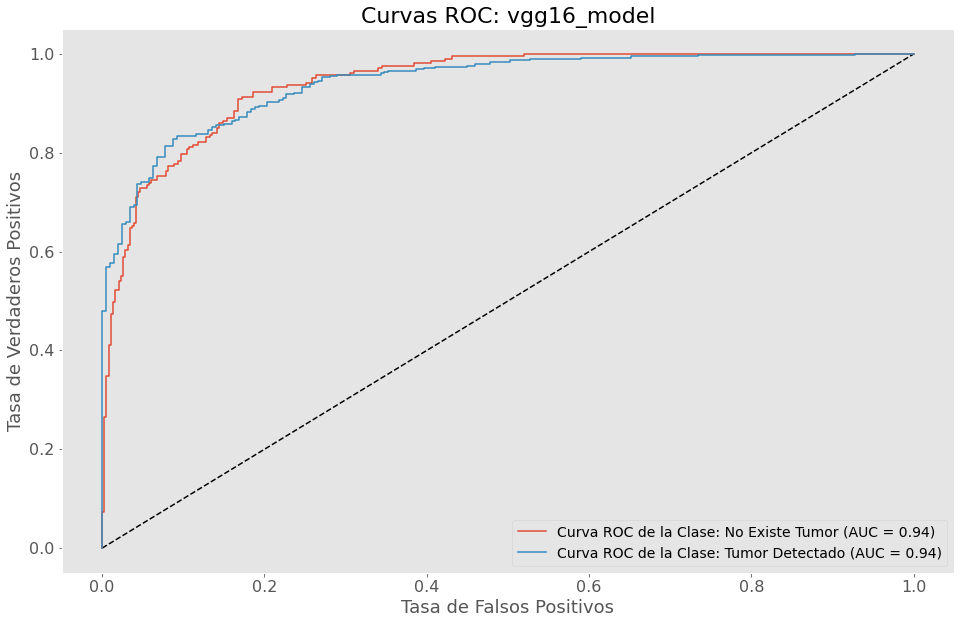

In [35]:
# Generar las predicciones del modelo
prob_test_prediction = loaded_model.predict(test_generator)

# Aquí asumimos que la clase positiva es la segunda columna de prob_test_prediction
test_prediction = prob_test_prediction[:, 1]

# Calcula la tasa de verdaderos positivos (TPR), la tasa de falsos positivos (FPR)
# y los umbrales para ambas clases utilizando la función roc_curve
fpr, tpr, umbrales = roc_curve(test_generator.labels, test_prediction, pos_label=1)
fpr_neg, tpr_neg, umbrales_neg = roc_curve(test_generator.labels, 1 - test_prediction, pos_label=0)

# Calcula el área bajo la curva (AUC) para ambas clases
roc_auc = auc(fpr, tpr)
roc_auc_neg = auc(fpr_neg, tpr_neg)

# Grafica las curvas ROC para ambas clases
plt.style.use('ggplot')
plt.figure(figsize=(16,10))
plt.plot([0, 1], [0, 1], "k--")
plt.title(r"Curvas ROC: " + "vgg16_model", size=22)
plt.plot(fpr, tpr, label='Curva ROC de la Clase: No Existe Tumor (AUC = %0.2f)' % roc_auc)
plt.plot(fpr_neg, tpr_neg, label='Curva ROC de la Clase: Tumor Detectado (AUC = %0.2f)' % roc_auc_neg)
plt.xlabel(r"Tasa de Falsos Positivos", size=18)
plt.ylabel(r"Tasa de Verdaderos Positivos", size=18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.grid()
plt.savefig("../reports/" + 'roc_curve_' + "vgg16_model" + '.png')
plt.show()